In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [107]:
data = pd.read_csv('/kaggle/input/climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByCity.csv')

In [108]:
data.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [109]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599212 entries, 0 to 8599211
Data columns (total 7 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   dt                             object 
 1   AverageTemperature             float64
 2   AverageTemperatureUncertainty  float64
 3   City                           object 
 4   Country                        object 
 5   Latitude                       object 
 6   Longitude                      object 
dtypes: float64(2), object(5)
memory usage: 459.2+ MB


In [207]:
def clean_df(df):
    return (df
        .assign(
            dt= lambda df_: pd.to_datetime(df_['dt']) 
        )
        .loc[(df['City'] == 'Kathmandu') & (df['dt'] >= '2000-01-01')] 
        .drop(columns= ['AverageTemperatureUncertainty', 'Country','City','Latitude','Longitude']) 
        .set_index('dt') 
        .resample('MS') 
        .interpolate(motehod= 'time') 
    )

In [208]:
clean_data = clean_df(data)

In [209]:
clean_data.head()

,AverageTemperature
dt,
2000-01-01,6.359
2000-02-01,6.682
2000-03-01,11.902
2000-04-01,17.033
2000-05-01,19.842


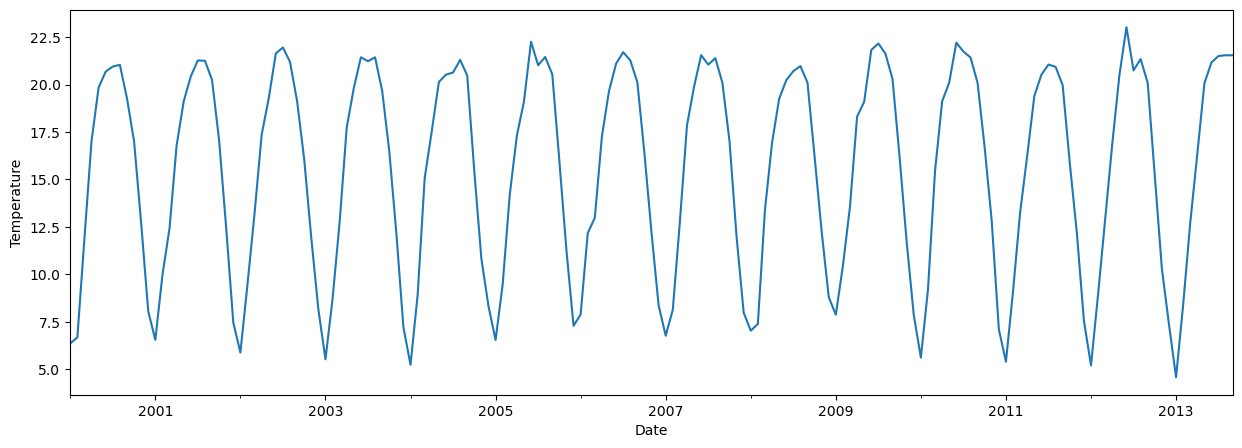

In [210]:

clean_data.plot(figsize = (15,5),xlabel = "Date", ylabel = "Temperature",legend = None)
plt.show()

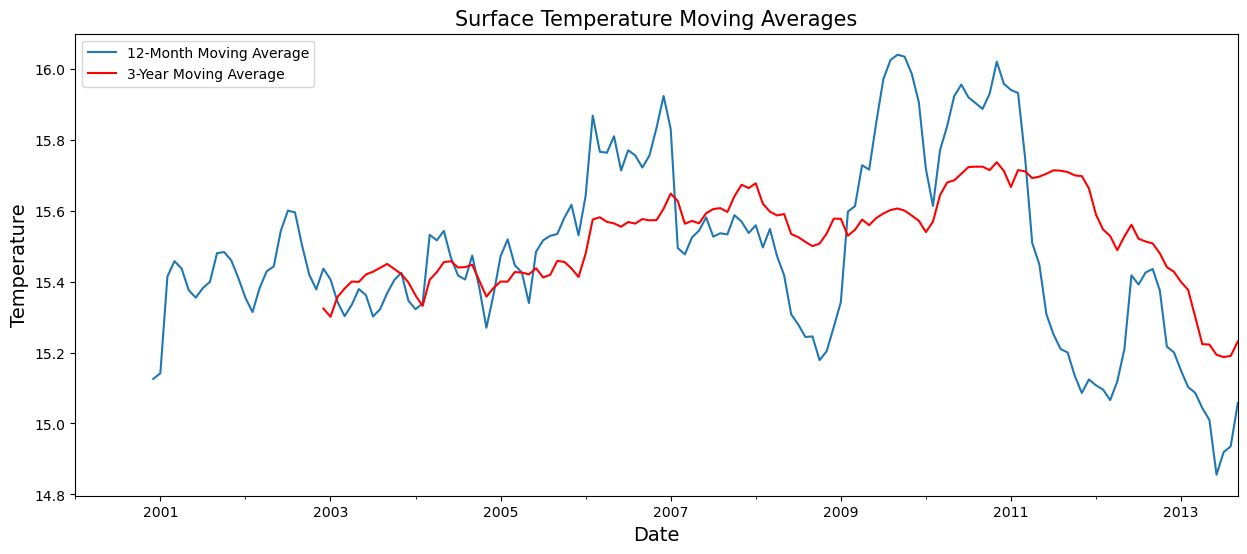

In [211]:
yearly = clean_data['AverageTemperature'].rolling(window = 12).mean()
threeyearly = clean_data['AverageTemperature'].rolling(window = 36).mean()

MAax = yearly['1990':].plot(figsize = (15, 6), label = '12-Month Moving Average')
threeyearly['1990':].plot(ax = MAax, color = 'red', label = '3-Year Moving Average')

plt.xlabel('Date', fontsize = 14)
plt.ylabel('Temperature', fontsize = 14)
plt.title('Surface Temperature Moving Averages', fontsize = 15)
plt.legend()
plt.show()

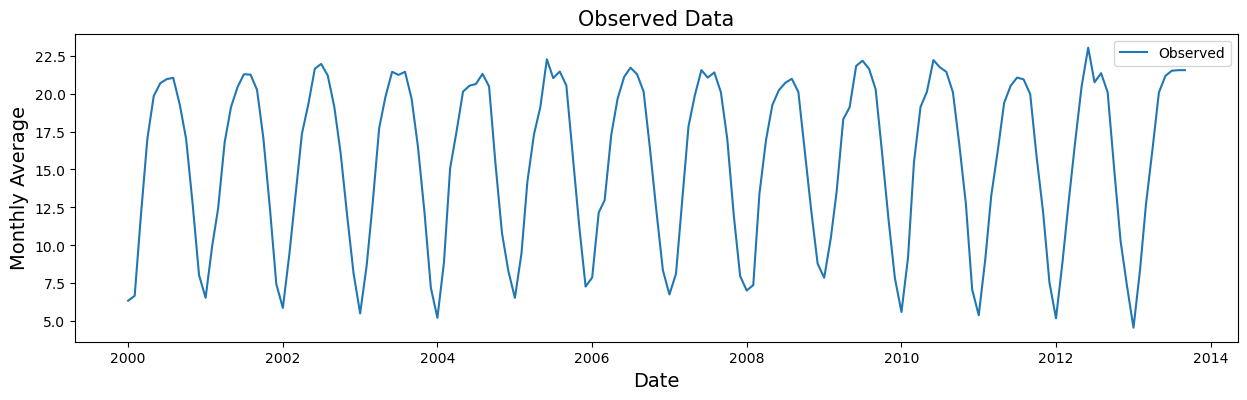

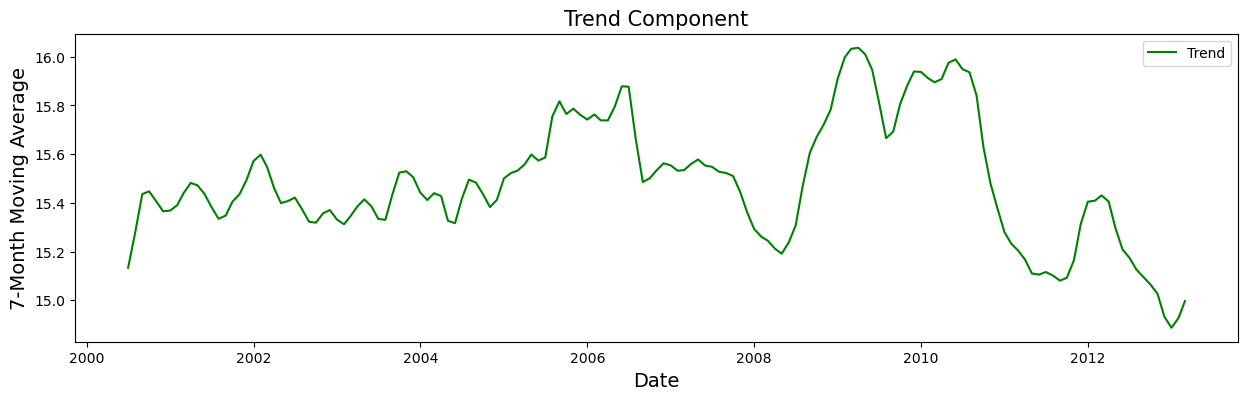

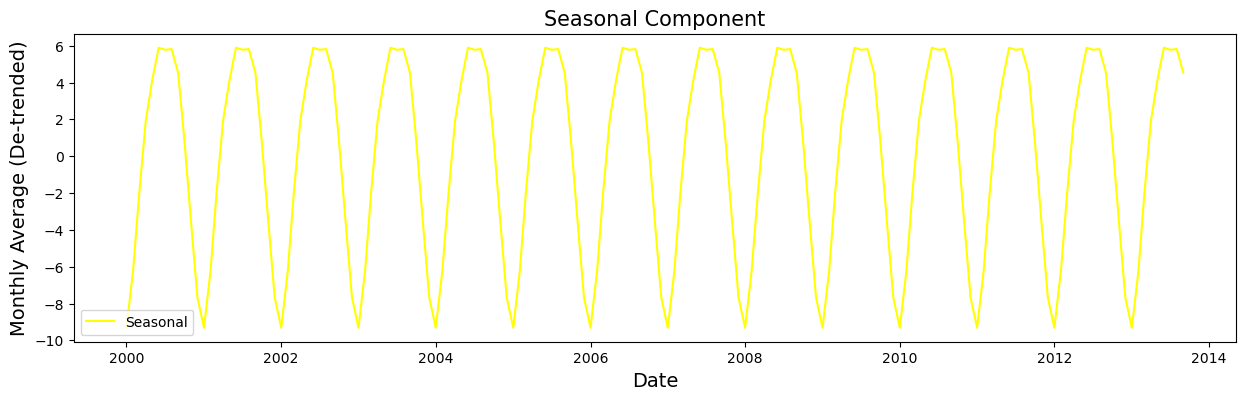

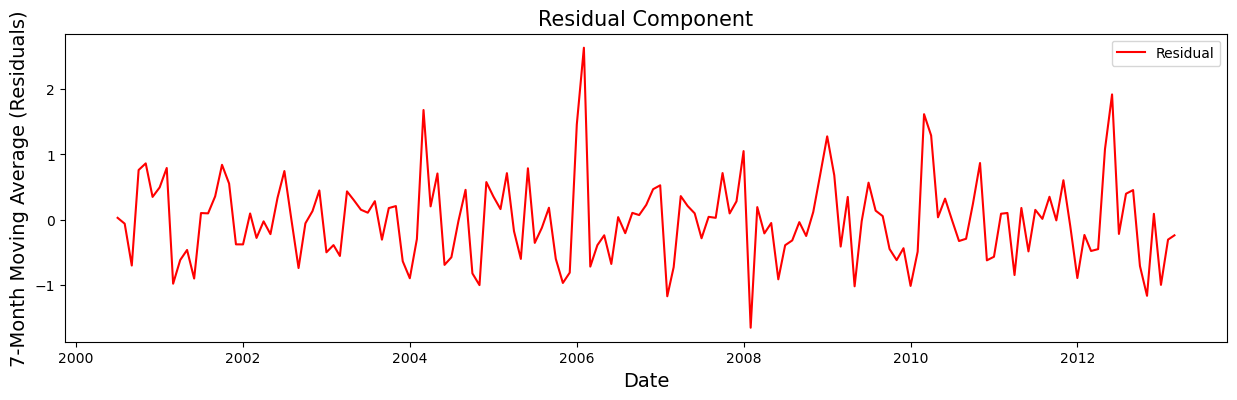

In [212]:
'''   We can also visualize our data 
using a method called 
time-series decomposition 
that allows us to decompose
our time series into three
distinct components: trend, seasonality, and noise.  '''

from statsmodels.tsa.seasonal import seasonal_decompose


decomposition = seasonal_decompose(clean_data)

# observed values:
observed = decomposition.observed
plt.figure(figsize = (15, 4))
plt.plot(observed, label = 'Observed')
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Monthly Average', fontsize = 14)
plt.legend(loc = 'best')
plt.title("Observed Data", fontsize = 15)
plt.show()

# component:
trend = decomposition.trend
plt.figure(figsize = (15, 4))
plt.plot(trend, label = 'Trend', color = 'green')
plt.xlabel('Date', fontsize = 14)
plt.ylabel('7-Month Moving Average', fontsize = 14)
plt.legend(loc = 'best')
plt.title("Trend Component", fontsize = 15)
plt.show()

#P component:
seasonal = decomposition.seasonal
plt.figure(figsize = (15, 4))
plt.plot(seasonal, label = 'Seasonal', color = 'yellow')
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Monthly Average (De-trended)', fontsize = 14)
plt.legend(loc = 'best')
plt.title("Seasonal Component", fontsize = 15)
plt.show()

#component:
residual = decomposition.resid
plt.figure(figsize = (15, 4))
plt.plot(residual, label = 'Residual', color = 'red')
plt.xlabel('Date', fontsize = 14)
plt.ylabel('7-Month Moving Average (Residuals)', fontsize = 14)
plt.legend(loc = 'best')
plt.title("Residual Component", fontsize = 15)
plt.show()

<AxesSubplot:xlabel='dt'>

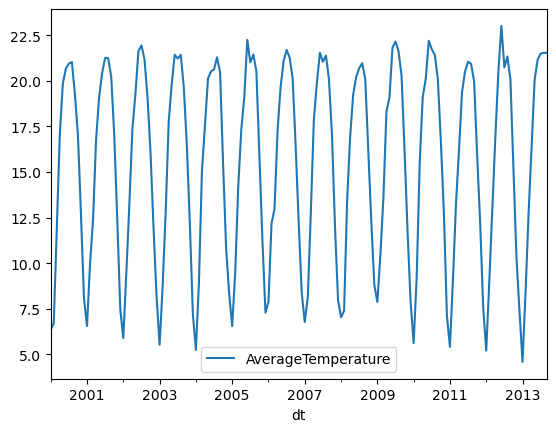

In [213]:
clean_data.plot()

In [214]:
# train test split
train_size = 0.8
clean_data.head()

,AverageTemperature
dt,
2000-01-01,6.359
2000-02-01,6.682
2000-03-01,11.902
2000-04-01,17.033
2000-05-01,19.842


In [215]:
train_loc = int(train_size * clean_data.shape[0])
train_data= clean_data.iloc[:train_loc]
test_data = clean_data.iloc[train_loc:]

print(train_data.shape,test_data.shape)

(132, 1) (33, 1)


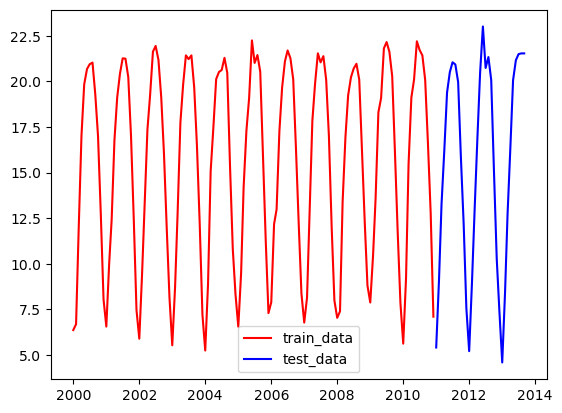

In [216]:
plt.plot(train_data,color = 'red',label = 'train_data')
plt.plot(test_data, color = 'blue', label = 'test_data')
plt.legend(loc = 'best')
plt.show()

In [217]:
import xgboost as xgb

def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['day'] = df['date'].dt.day
    df['target'] = df['AverageTemperature']
    
    X = df[['year','month','day']]
    y = df['target']
  
    return X, y
    

In [218]:
X_train,y_train = create_features(train_data)
X_test,y_test = create_features(test_data)

In [219]:
reg = xgb.XGBRegressor(n_estimators = 1000,early_stopping_rounds = 50,learning_rate = 0.01)

reg.fit(X_train,y_train,eval_set = [(X_train,y_train),(X_test,y_test)],verbose = 10)

[0]	validation_0-rmse:15.80189	validation_1-rmse:15.92283
[10]	validation_0-rmse:14.34005	validation_1-rmse:14.44488
[20]	validation_0-rmse:13.01681	validation_1-rmse:13.10710
[30]	validation_0-rmse:11.81898	validation_1-rmse:11.89250
[40]	validation_0-rmse:10.73291	validation_1-rmse:10.78439
[50]	validation_0-rmse:9.74748	validation_1-rmse:9.77712
[60]	validation_0-rmse:8.85402	validation_1-rmse:8.86491
[70]	validation_0-rmse:8.04373	validation_1-rmse:8.03641
[80]	validation_0-rmse:7.30925	validation_1-rmse:7.28681
[90]	validation_0-rmse:6.64340	validation_1-rmse:6.60642
[100]	validation_0-rmse:6.04013	validation_1-rmse:5.99125
[110]	validation_0-rmse:5.49354	validation_1-rmse:5.43314
[120]	validation_0-rmse:4.99866	validation_1-rmse:4.92937
[130]	validation_0-rmse:4.55010	validation_1-rmse:4.47281
[140]	validation_0-rmse:4.14362	validation_1-rmse:4.05991
[150]	validation_0-rmse:3.77477	validation_1-rmse:3.68670
[160]	validation_0-rmse:3.44028	validation_1-rmse:3.34801
[170]	validatio

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

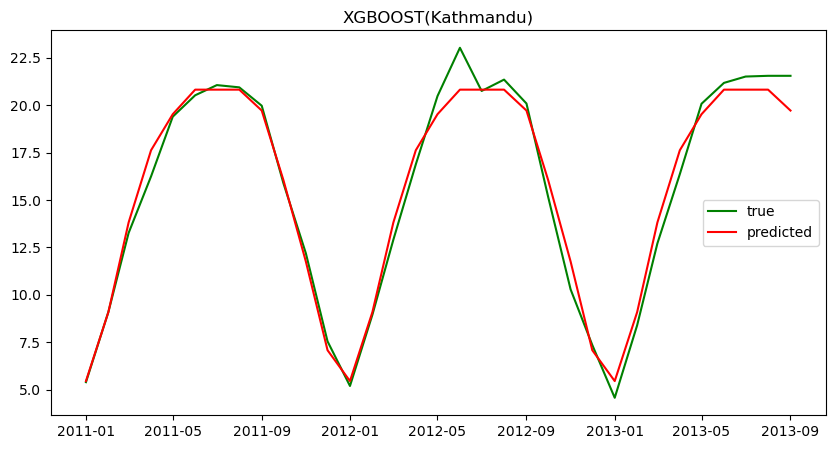

In [220]:
test_data['predicted'] = reg.predict(X_test)

plt.figure(figsize = (10,5))
plt.title('XGBOOST(Kathmandu)')
plt.plot(test_data.AverageTemperature,color = 'green',label = 'true')
plt.plot(test_data.predicted, color = 'red', label = 'predicted')
plt.legend(loc = 'right')
plt.show()